In [7]:
# Are we using a GPU?
!nvidia-smi

Sun Jun 20 07:30:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## TensorFlow Hub ile öğrenimi aktarın: Verilerin %10'u ile harika sonuçlar elde edin

"Elbette bir başkası bu iş için doğru modeli yapmak için zaman harcadı..." diye düşünüyorsanız, şanslısınız demektir.

Derin öğrenmeyi kullanmak isteyeceğiniz sorunların çoğu için, muhtemelen çalışan bir model zaten mevcuttur.

Ve iyi haber şu ki, çoğuna TensorFlow Hub'dan erişebilirsiniz.

[TensorFlow Hub](https://tfhub.dev/), mevcut model bileşenleri için bir havuzdur. Bir URL kadar az olan tam eğitimli bir modeli içe aktarabilmenizi ve kullanabilmenizi sağlar.

Şimdi, size transfer öğrenmenin gücünü gerçekten göstermek istiyorum.

Bunu yapmak için, orijinal verinin yalnızca %10'u ile, yani 10 kat daha az veri ile şimdiye kadar elde ettiğimiz en iyi modelimizin elde ettiği sonuçların çoğunu (veya daha iyisini) elde edebileceğimizi söylesem ne olur?

Bu mantıksız görünüyor değil mi?

Bir yemek resminin nasıl göründüğüne dair daha fazla örneğin daha iyi sonuçlara yol açtığını düşünmez miydiniz?

Ve genel olarak, daha fazla verinin daha iyi sonuçlara yol açtığını düşünüyorsanız haklısınız.

Ancak, ya daha fazla veriye sahip değilseniz? Sınıf başına 750 görsel yerine, sınıf başına 75 görseliniz olsaydı ne olurdu?

Belirli bir sınıfa ait 675 resim daha toplamak uzun zaman alabilir.

İşte transfer öğreniminin bir başka önemli faydası da burada devreye giriyor.

Aktarım öğrenimi genellikle daha az veriyle harika sonuçlar elde etmenizi sağlar.

Ama sadece benim sözüme bakma. Kullanmakta olduğumuz verilerin bir alt kümesini, yani 10_food_classes veri kümesindeki eğitim verilerinin %10'unu indirelim ve bunu bir gıda görüntüsü sınıflandırıcısını eğitmek için kullanalım.

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-transfer-learning-feature-extraction.png" />

## Veriyi indirme

In [8]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-06-20 07:30:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.128, 142.250.101.128, 142.251.2.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   277MB/s    in 0.6s    

2021-06-20 07:30:07 (277 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [9]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

Eğitim dizinlerinin her birinin artık 750 görüntü yerine 75 görüntüye sahip olduğuna dikkat edin. Bu, transfer öğreniminin daha az etiketli görüntülerle ne kadar iyi performans gösterebileceğini göstermenin anahtarıdır.

Test dizinleri hala aynı miktarda görüntüye sahip. Bu, daha az veri üzerinde eğitim yapacağımız, ancak modellerimizi aynı miktarda test verisi üzerinde değerlendireceğimiz anlamına geliyor.

## Veri yükleyicileri oluşturma (verileri hazırlama)

Verileri indirdik, şimdi `imageDataGenerator` sınıfını ve `flow_from_directory` yöntemini kullanarak resimlerimizi yükleyelim.

In [10]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


Mükemmel! Verileri yüklediğimizde, 10 sınıfa (sınıf başına 75) ait eğitim veri setinde 750 görüntü ve 10 sınıfa ait (sınıf başına 250) test setinde 2500 görüntü olduğunu görüyoruz.

## Callback'leri ayarlama (modelimiz eğitilirken çalıştırılacak şeyler)

Bir model oluşturmadan önce, aşina olacağımız önemli bir kavram var çünkü gelecekteki model oluşturma deneylerimizde kilit bir rol oynayacak.

Ve bu kavram Callback.

[Callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks), eğitim sırasında veya sonrasında gerçekleştirilmek üzere modellerinize ekleyebileceğiniz ekstra işlevlerdir. En popüler callback'lerden bazıları şunlardır:
- [**TensorBoard ile deney izleme**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard)<br> - birden fazla modelin performansını günlüğe kaydedin ve ardından bu modelleri TensorBoard'da (sinir ağı parametrelerini incelemek için bir gösterge panosu) görsel bir şekilde görüntüleyin ve karşılaştırın. Verileriniz üzerinde farklı modellerin sonuçlarını karşılaştırmanıza yardımcı olur.
- [**Model checkpointing**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)<br> - Modelinizi eğitirken kaydedin, böylece gerekirse eğitimi durdurabilir ve kaldığınız yerden devam etmek için geri dönebilirsiniz. Antrenman uzun sürüyorsa ve bir oturuşta yapılamıyorsa faydalıdır.
- [**Early Stopping**](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)<br> - model eğitiminizi isteğe bağlı bir süre için bırakın ve gelişme sona erdiğinde eğitimi otomatik olarak durdurmasını sağlayın. Büyük bir veri kümeniz olduğunda ve eğitimin ne kadar süreceğini bilmediğinizde faydalıdır.

Bu fazla mesainin her birini inceleyeceğiz, ancak bu defter için TensorBoard geri aramasının nasıl kullanılabileceğini göreceğiz.

TensorBoard geri çağrısına `tf.keras.callbacks.TensorBoard()` kullanılarak erişilebilir.

Ana işlevi, bir modelin eğitim performans ölçümlerini belirtilen bir log_dir'e kaydetmektir.

Varsayılan olarak, günlükler update_freq='epoch' parametresi kullanılarak her çağda kaydedilir. Bu iyi bir varsayılandır, çünkü model performansının izlenmesi sıklıkla model eğitimini yavaşlatabilir.

TensorBoard kullanarak modelleme deneylerimizi izlemek için, bizim için bir TensorBoard geri çağrısı oluşturan bir fonksiyon oluşturalım.

> 🔑 Not: Bir TensorBoard geri çağrısı oluşturmak için bir fonksiyon yaratırız çünkü daha sonra göreceğimiz gibi, her model kendi TensorBoard geri çağırma örneğine ihtiyaç duyar (böylece fonksiyon her çalıştırıldığında yeni bir tane yaratacaktır).

In [11]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Birden fazla deneme çalıştırmanız muhtemel olduğundan, bunları bir şekilde takip edebilmek iyi bir fikirdir.

Bizim durumumuzda, fonksiyonumuz bir modelin performans günlüklerini `[dir_name]/[experiment_name]/[current_timestamp]` adlı bir dizine kaydeder, burada:

- `dir_name` genel günlükler dizinidir
- `experiment_name` belirli bir deneydir
- `current_timestamp` Python'un datetime.datetime().now() değerine dayalı olarak deneyin başladığı zamandır

> 🔑 Not: Kullanım durumunuza bağlı olarak, yukarıdaki deneme amaçlı izleme adlandırma yöntemi işe yarayabilir veya daha spesifik bir şeye ihtiyacınız olabilir. İyi haber şu ki, TensorBoard geri araması, onları nerede izleyeceğinizi belirttiğiniz sürece modelleme günlüklerini izlemeyi kolaylaştırır. Böylece, deneylerinizi nasıl adlandırdığınız konusunda istediğiniz kadar yaratıcı olabilirsiniz, sadece sizin veya ekibinizin onları anlayabildiğinden emin olun.

## TensorFlow Hub kullanarak model oluşturma

Geçmişte, sıfırdan katman katman kendi modellerimizi oluşturmak için TensorFlow'u kullandık.

Şimdi benzer bir işlem yapacağız, ancak modelimizin katmanlarının çoğu TensorFlow Hub'dan gelecek.

Aslında, TensorFlow Hub'dan iki model kullanacağız:

- **ResNetV2**<br>2016'dan itibaren son teknoloji bir bilgisayarlı görü modeli mimarisi.
- **EfficientNet**<br>2019'dan itibaren son teknoloji bir bilgisayarlı görü mimarisi.

Son teknoloji, bir noktada, bu modellerin her ikisinin de bilgisayarla görme kıyaslamalarının altın standardı olan ImageNet'te (ILSVRC-2012-CLS) en düşük hata oranını elde ettiği anlamına gelir.

Merak ediyor olabilirsiniz, bu modelleri TensorFlow Hub'da nasıl buluyorsunuz?

İşte attığım adımlar:

1. tfhub.dev'e gidin.
2. Sorunlu etki alanınızı seçin, ör. "Görüntü" (yemek resimleri kullanıyoruz).
3. Bizim durumumuzda TF2 olan TF sürümünüzü seçin.
4. Üzerinde çalıştığınız sorun dışındaki tüm "Problem Domain" filtrelerini kaldırın.
  - **Not:** "Image feature vector" hemen hemen her problemin yanında kullanılabilir, buna birazdan geleceğiz.
Listelenen modeller, probleminiz için potansiyel olarak kullanılabilecek tüm modellerdir.

> 🤔 **Soru:**<br> Görüntü sınıflandırma modelleri için birçok seçenek görüyorum, hangisinin en iyi olduğunu nasıl bileceğim?

En son modellerin bir listesini [paperswithcode.com](https://www.paperswithcode.com/)'da görebilirsiniz; bu kaynak, raporladıkları bulgular için kod uygulamalarına sahip en son derin öğrenme makalesi sonuçlarını toplamak için bir kaynaktır.

Görüntülerle çalıştığımız için hedefimiz [ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet)'te en iyi performansı gösteren modeller.

Muhtemelen kodlu kağıtlarda listelenen model mimarilerinin tümünün TensorFlow Hub'da görünmediğini göreceksiniz. Ve bu sorun değil, hala mevcut olanı kullanabiliriz.

6. TensorFlow Hub'da Mimari sekmesini seçin ve mimari adlarından oluşan bir açılır menünün göründüğünü göreceksiniz.
  - Buradaki temel kural genellikle, daha büyük sayılara sahip isimler daha iyi performans gösteren modeller anlamına gelir. Örneğin, EfficientNetB4, EfficientNetB0'dan daha iyi performans gösterir.
    - Bununla birlikte, daha büyük sayılarla yapılan ödünleşim, hesaplamanın daha uzun sürdüğü anlamına gelebilir.

7. EfficientNetB0'ı seçin ve aşağıdakine benzer bir şey görmelisiniz:

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-tensorflow-hub-efficientnetb0.png" />

8. ["efficientnet/b0/feature-vector"](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) başlığına tıklamak bizi "URL'yi kopyala" yazan bir buton içeren bir sayfaya getiriyor. Bu URL, EfficientNetB0'ın gücünden yararlanmak için kullanabileceğimiz şeydir.
  - URL'yi kopyalamak size şöyle bir şey vermelidir: https://tfhub.dev/tensorflow/quality/b0/feature-vector/1

> 🤔 Soru: Görüntü sınıflandırması yaptığımızı sanıyordum, neden sınıflandırma değil de özellik vektörünü seçiyoruz?

Harika gözlem. Bu, özellik çıkarma ve ince ayar gibi farklı aktarım öğrenme türlerinin devreye girdiği yerdir.

1. **"As is" transfer öğrenme**, önceden eğitilmiş bir modeli olduğu gibi alıp herhangi bir değişiklik yapmadan görevinize uyguladığınız zamandır.

  - Örneğin, birçok bilgisayarlı görü modeli, 1000 farklı görüntü sınıfını içeren ImageNet veri kümesi üzerinde önceden eğitilmiştir. Bu, bu modele tek bir görüntünün geçirilmesinin 1000 farklı tahmin olasılığı değeri (her sınıf için 1) üreteceği anlamına gelir.

    - Sınıflandırmak istediğiniz 1000 görüntü sınıfınız varsa ve bunların tümü ImageNet sınıflarıyla aynıysa bu yararlıdır, ancak yalnızca küçük bir sınıf alt kümesini (10 farklı tür gibi) sınıflandırmak istiyorsanız bu yararlı değildir. gıda). TensorFlow Hub'da adlarında "/classification" bulunan modeller bu tür bir işlevsellik sağlar.

2. **Özellik çıkarma transferi öğrenimi**, önceden eğitilmiş bir modelin öğrendiği temel kalıpları (ağırlıklar da denir) aldığınızda ve çıktılarını probleminize daha uygun olacak şekilde ayarladığınızda gerçekleşir.

  - Örneğin, kullandığınız önceden eğitilmiş modelin 236 farklı katmanı olduğunu varsayalım (EfficientNetB0'ın 236 katmanı vardır), ancak ImageNet'te önceden eğitildiği için üst katman 1000 sınıf verir. Bunu kendi probleminize göre ayarlamak için, orijinal etkinleştirme katmanını kaldırabilir ve onu kendinizle ancak doğru sayıda çıktı sınıfıyla değiştirebilirsiniz. Buradaki önemli kısım, sadece en üstteki birkaç katmanın eğitilebilir hale gelmesi, geri kalanının donmuş kalmasıdır.

    - Bu şekilde, temeldeki tüm desenler diğer katmanlarda kalır ve bunları kendi probleminiz için kullanabilirsiniz. Bu tür aktarım öğrenimi, verileriniz bir modelin önceden eğitilmiş olduğu verilere benzer olduğunda çok faydalıdır.

3. **İnce ayarlı (fine tuning) transfer öğrenimi**, önceden eğitilmiş bir modelin temel modellerini (ağırlık olarak da adlandırılır) aldığınız ve bunları kendi probleminize göre ayarladığınız (ince ayar yaptığınız) zamandır.

  - Bu genellikle önceden eğitilmiş modeldeki katmanların bir kısmının, çoğunun veya tamamının eğitilmesi anlamına gelir. Bu, verilerinizin orijinal modelin eğitildiği verilerden biraz farklı olduğu büyük bir veri kümeniz (ör. sınıf başına 100'den fazla görüntü) olduğunda kullanışlıdır.

Yaygın bir iş akışı, önceden eğitilmiş bir modelin alt katmanlarında öğrenilen tüm kalıpları "dondurarak" eğitilemez hale getirmektir. Ardından, önceden eğitilmiş modelin çıktılarını özel verilerinize göre ayarlayabilmesi için üst 2-3 katmanını eğitin (özellik çıkarma).

İlk 2-3 katmanı eğittikten sonra, giderek daha fazla katmanı kademeli olarak "çözebilir" ve önceden eğitilmiş modelde daha fazla ince ayar yapmak için eğitim sürecini kendi verileriniz üzerinde çalıştırabilirsiniz.

> 🤔 Soru: Özellik çıkarmada neden yalnızca ilk 2-3 katmanı eğitelim?

Bir bilgisayarlı görü modelinde bir katman ne kadar düşükse, girdi katmanına ne kadar yakınsa, öğrendiği özellikler o kadar büyük olur. Örneğin, kedilerin veya köpeklerin görüntülerini tanımlamak için bir bilgisayarlı görme modelindeki bir alt katman, bacakların ana hatlarını öğrenebilirken, çıktıya daha yakın katmanlar dişlerin şeklini öğrenebilir. Çoğu zaman, daha büyük özelliklerin (öğrenilmiş kalıplar aynı zamanda özellikler olarak da adlandırılır) kalmasını istersiniz, çünkü bunlar her iki hayvan için de benzerdir, ancak farklılıklar daha ince taneli özelliklerde kalır.

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-different-kinds-of-transfer-learning.png" />

Tamam, yeterince konuşma, bunu eylemde görelim. Bir kez yaptığımızda, neler olduğunu açıklayacağız.

İlk önce TensorFlow ve TensorFlow Hub'ı içe aktaracağız.

In [12]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

Şimdi, yukarıdaki adımları kullanarak TensorFlow Hub'dan iki yaygın bilgisayarlı görü mimarisinin, [EfficientNetB0 (2019)](https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1) ve [ResNetV250 (2016)](https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4) özellik vektör URL'lerini alacağız.

Her ikisini de alıyoruz çünkü verilerimizde hangisinin daha iyi performans gösterdiğini görmek için onları karşılaştıracağız.

> 🔑 Not: Aynı veriler üzerinde farklı model mimarisi performansının karşılaştırılması çok yaygın bir uygulamadır. Bunun basit nedeni, probleminiz için hangi modelin en iyi performansı gösterdiğini bilmek istemenizdir.

In [13]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

Bu URL'ler, TensorFlow Hub'da kaydedilmiş önceden eğitilmiş bir modele bağlanır.

Bunları modelimizde kullandığımızda, model otomatik olarak indirilip kullanmamız için indirilecektir.

Bunu yapmak için TensorFlow hub kitaplığı içindeki [KerasLayer()](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) modelini kullanabiliriz.

İki modeli karşılaştıracağımızdan, kendi kodumuzdan tasarruf etmek için bir `create_model()` işlevi yaratacağız. Bu işlev, bir modelin TensorFlow Hub URL'sini alacak, uygun sayıda çıktı katmanına sahip bir Keras Sıralı modeli oluşturacak ve modeli döndürecektir.

In [14]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

Harika! Şimdi bir model oluşturmak için bir fonksiyonumuz var, bunu ilk önce özellik çıkarma katmanımız olarak ResNetV250 mimarisini kullanarak bir model oluşturmak için kullanacağız.

Model somutlaştırıldıktan sonra, kayıp fonksiyonumuz olarak `categorical_crossentropy`'yi, metriğimiz olarak Adam optimizer'ı ve doğruluğu kullanarak onu derleyeceğiz.

In [15]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

<img src="https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/04-resnet-feature-extractor.png" />

Mevcut modelimiz nasıl görünüyor. Üstte özel bir yoğun katmana sahip bir ResNet50V2 omurgası (1000 ImageNet sınıfı yerine 10 sınıf). Not: Resim, ResNet50 yerine ResNet34'ü gösterir. Resim kaynağı: [https://arxiv.org/abs/1512.03385](https://arxiv.org/abs/1512.03385).

Güzel. Modele uyma zamanı.

Train_data_10_percent içindeki eğitim verilerini ve test_data olarak kaydedilen test verilerini hazırladık.

Ancak fit işlevini çağırmadan önce, ekleyeceğimiz bir şey daha var, bir callback. Daha spesifik olarak, modelimizin performansını TensorBoard'da izleyebilmemiz için bir TensorBoard callback.

Fit fonksiyonunda callbacks parametresini kullanarak modelimize bir callback ekleyebiliriz.

Bizim durumumuzda, daha önce oluşturduğumuz `create_tensorboard_callback()` parametresini bazı özel girdilerle ileteceğiz, böylece hangi deneyleri çalıştırdığımızı bileceğiz.

Bu deneyi kısa tutalım ve 5 epoch boyunca antrenman yapalım.


In [16]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210620-073251
Epoch 1/5
24/24 [==============================] - 51s 756ms/step - loss: 2.0198 - accuracy: 0.3613 - val_loss: 1.2526 - val_accuracy: 0.6076
Epoch 2/5
24/24 [==============================] - 15s 645ms/step - loss: 0.9134 - accuracy: 0.7467 - val_loss: 0.8639 - val_accuracy: 0.7304
Epoch 3/5
24/24 [==============================] - 15s 645ms/step - loss: 0.6419 - accuracy: 0.8280 - val_loss: 0.7678 - val_accuracy: 0.7628
Epoch 4/5
24/24 [==============================] - 15s 644ms/step - loss: 0.4844 - accuracy: 0.8720 - val_loss: 0.7259 - val_accuracy: 0.7732
Epoch 5/5
24/24 [==============================] - 15s 641ms/step - loss: 0.3895 - accuracy: 0.9053 - val_loss: 0.6912 - val_accuracy: 0.7740


Vaov!

Görünüşe göre sadece 5 epcoh'tan sonra, ResNetV250 özellik çıkarma modeli, yaptığımız mimarilerden herhangi birini sudan çıkarabildi ve eğitim setinde yaklaşık %90 doğruluk ve test setinde yaklaşık %80 doğruluk elde etti... eğitim görüntülerinin sadece yüzde 10'u!

Bu, transfer öğrenmenin gücünü gösterir. Ve bu, kendi veri kümelerinizi modellemeye çalıştığınızda ana nedenlerden biridir, önceden eğitilmiş modellerin zaten var olduğuna bakmalısınız.

`Plot_loss_curves` fonksiyonumuzu kullanarak modelimizin eğitim eğrilerini kontrol edelim.

In [17]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

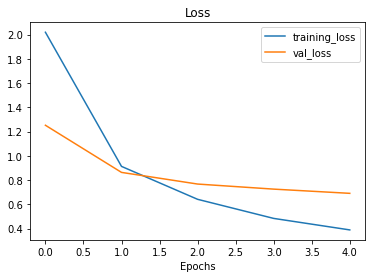

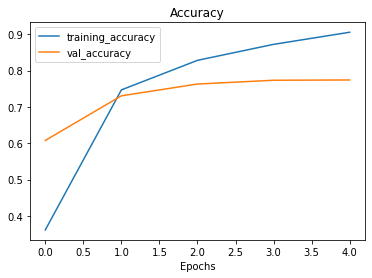

In [18]:
plot_loss_curves(resnet_history)

Peki ya modelimizin bir özeti?

In [19]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


TensorFlow Hub'ın gücünü burada görebilirsiniz. Özellik çıkarma katmanı, modelin ImageNet veri kümesinde önceden öğrenmiş olduğu önceden öğrenilmiş desenler olan 23.564.800 parametreye sahiptir. Trainable=False ayarını yaptığımız için, bu modeller eğitim sırasında donmuş (eğitilemez) olarak kalır.

Bu, eğitim sırasında modelin çıktı katmanındaki 20.490 parametreyi veri kümemize uyacak şekilde güncellediği anlamına gelir.

Tamam, bir ResNetV250 modelini eğittik, aynısını EfficientNetB0 modeliyle yapmanın zamanı geldi.

create_model() işlevindeki model_url parametresi ve create_tensorboard_callback() işlevindeki trial_name parametresi dışında kurulum öncekiyle tamamen aynı olacaktır.

In [20]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data_10_percent.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnet_history = efficientnet_model.fit(train_data_10_percent, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210620-073555
Epoch 1/5
24/24 [==============================] - 25s 764ms/step - loss: 1.8512 - accuracy: 0.4133 - val_loss: 1.2842 - val_accuracy: 0.7384
Epoch 2/5
24/24 [==============================] - 14s 619ms/step - loss: 1.0633 - accuracy: 0.7707 - val_loss: 0.8635 - val_accuracy: 0.8304
Epoch 3/5
24/24 [==============================] - 14s 614ms/step - loss: 0.7548 - accuracy: 0.8400 - val_loss: 0.6946 - val_accuracy: 0.8456
Epoch 4/5
24/24 [==============================] - 14s 609ms/step - loss: 0.6038 - accuracy: 0.8680 - val_loss: 0.6075 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 14s 614ms/step - loss: 0.5096 - accuracy: 0.8893 - val_loss: 0.5530 - val_accuracy: 0.8624


Aman Tanrım! `EfficientNetB0` modeli, `ResNetV250` modelinden bile daha iyisini yapar! Yine eğitim verilerinin yalnızca %10'u ile test setinde %85'in üzerinde doğruluk elde etmek.

Ne kadar cool?

Birkaç satır kodla, son teknoloji modellerden yararlanabiliyor ve bunları kendi kullanım durumumuza göre ayarlayabiliyoruz.

Kayıp eğrilerini kontrol edelim.

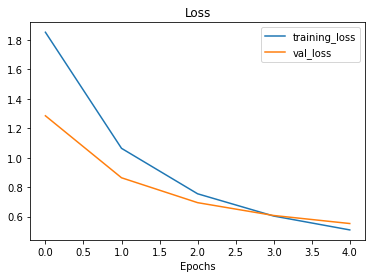

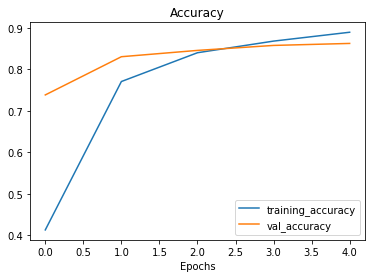

In [21]:
plot_loss_curves(efficientnet_history)

EfficientNetB0 modelinin kayıp eğrilerine bakıldığında, modelimizi daha uzun süre eğitmeye devam edersek, daha da gelişebilir gibi görünüyor. Belki de denemek isteyebileceğiniz bir şeydir?

Model özetini kontrol edelim.

In [22]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


ResNet50V2 çıkarma katmanından dört kat daha az parametreye (4.049.564'e karşı 23.564.800) sahip olmasına rağmen, EfficientNetB0 özellik çıkarma katmanı daha iyi performans sağlıyor gibi görünüyor. Şimdi "verimli" ismin nereden geldiği açık.

## TensorBoard kullanarak modelleri karşılaştırma

Pekala, doğruluk puanlarına bakarak iki modelimizin performansını zaten karşılaştırmış olmamıza rağmen. Peki ya ikiden fazla modeliniz varsa?

TensorBoard (Google Colab'a önceden yüklenmiş) gibi bir deneme izleme aracının devreye girdiği yer burasıdır.

İşin iyi yanı, bir TensorBoard geri araması oluşturduğumuzdan, modelimizin tüm eğitim günlükleri otomatik olarak kaydedildi. Bunları görselleştirmek için sonuçları TensorBoard.dev'e yükleyebiliriz.

Sonuçlarınızı TensorBoard.dev'e yüklemek, birden çok farklı modelleme deneyini izlemenize ve paylaşmanıza olanak tanır. Dolayısıyla, sonuçlarınızı birine göstermeniz gerekirse, onlara TensorBoard.dev'inize ve beraberindeki Colab not defterine bir bağlantı gönderebilirsiniz.

> 🔑 Not: Bu deneyler herkese açıktır, hassas verileri yüklemeyin. Gerekirse deneyleri silebilirsiniz.

TensorBoard'a bir dizi TensorFlow günlüğü yüklemek için aşağıdaki komutu kullanabiliriz:

```
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \ upload directory
  --name "EfficientNetB0 vs. ResNet50V2" \ 
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \ 
  --one_shot
```

- **--logdir** hedef yükleme dizinidir
- **--name** deneyin adıdır
- **--description**, deneyin kısa bir açıklamasıdır
- **--one_shot**, yükleme tamamlandığında TensorBoard yükleyicisinden çıkar

Tensorboard dev yükleme komutunu çalıştırmak, önce sizden TensorBoard.dev'e yüklemeyi yetkilendirmenizi isteyecektir. Yüklemeye yetki verdikten sonra günlük dosyalarınız yüklenecektir.

In [23]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-06-20 07:39:37.515573: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) y

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0

Aynı dizini tekrar yüklerseniz, onunla birlikte kullanabileceğiniz yeni bir deneme kimliği alırsınız.

Bu, denemelerinizi izlemek için yüklemelerinizi nasıl adlandırdığınıza bakmak isteyebilirsiniz. Bu şekilde, onları TensorBoard.dev'de bulduğunuzda, her deney sırasında ne olduğunu anlayabilirsiniz (örneğin, "verimlinet0_10_percent_data").

Yüklediğiniz tüm deneyleri görmek için şu komutu kullanabilirsiniz:

`tensorboard geliştirme listesi`

In [93]:
# Check out experiments
!tensorboard dev list

2021-06-20 09:17:44.114346: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No experiments. Use `tensorboard dev upload` to get started.


Unutmayın, TensorBoard.dev'e yapılan tüm yüklemeler herkese açıktır, bu nedenle bir deneyi silmek için şu komutu kullanabilirsiniz:

`tensorboard dev delete --experiment_id [INSERT_EXPERIMENT_ID]`

In [25]:
# Delete an experiment
!tensorboard dev delete --experiment_id xlfO945eSzyIZLkB97bNcQ

2021-06-20 07:44:22.941516: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Deleted experiment xlfO945eSzyIZLkB97bNcQ.


In [26]:
# Check to see if experiments still exist
!tensorboard dev list

2021-06-20 07:44:29.961383: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No experiments. Use `tensorboard dev upload` to get started.


## 🛠 Egzersizler

1. Burada sahip olduğumuz aynı verileri kullanarak bir model oluşturun ve sığdırın, ancak TensorFlow Hub'dan MobileNetV2 mimarisi özellik çıkarma ([mobilenet_v2_100_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) ile diğer modellerimizle karşılaştırıldığında nasıl bir performans sergiliyor?
2. TensorFlow Hub'da kullanmadığımız 3 farklı görüntü sınıflandırma modelini adlandırın.
3. Fotoğrafını çektiğiniz iki farklı şeyin görüntülerini sınıflandırmak için bir model oluşturun.
  - Bunun için TensorFlow Hub'dan istediğiniz herhangi bir özellik çıkarma katmanını kullanabilirsiniz.
  - Her sınıftan en az 10 görüntüye sahip olmayı hedeflemelisiniz, örneğin bir buzdolabı ve fırın sınıflandırıcısı oluşturmak için, 10 buzdolabı görüntüsü ve 10 fırın görüntüsü isteyeceksiniz.
4. ImageNet'teki mevcut en iyi performans gösteren model nedir?
  - İpucu: Bunun için [sotabench.com](https://www.sotabench.com/)'u kontrol etmek isteyebilirsiniz.

In [27]:
mobilenet_v2_100_224_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
mobilenet_model = create_model(model_url=mobilenet_v2_100_224_url,
                                  num_classes=train_data_10_percent.num_classes)

mobilenet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                        experiment_name="mobilenet_v2_100_224")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet_v2_100_224/20210620-080752
Epoch 1/5
24/24 [==============================] - 19s 690ms/step - loss: 1.9783 - accuracy: 0.3440 - val_loss: 1.3196 - val_accuracy: 0.5940
Epoch 2/5
24/24 [==============================] - 14s 614ms/step - loss: 1.0252 - accuracy: 0.7093 - val_loss: 0.8872 - val_accuracy: 0.7308
Epoch 3/5
24/24 [==============================] - 14s 613ms/step - loss: 0.7289 - accuracy: 0.8040 - val_loss: 0.7465 - val_accuracy: 0.7712
Epoch 4/5
24/24 [==============================] - 14s 604ms/step - loss: 0.5741 - accuracy: 0.8547 - val_loss: 0.6907 - val_accuracy: 0.7876
Epoch 5/5
24/24 [==============================] - 14s 609ms/step - loss: 0.4702 - accuracy: 0.8867 - val_loss: 0.6489 - val_accuracy: 0.7968


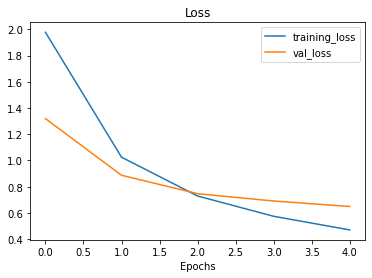

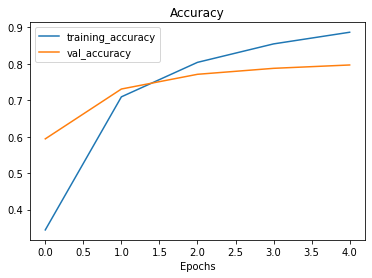

In [28]:
plot_loss_curves(mobilenet_history)

In [29]:
mobilenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              2257984   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [31]:
mobilenet_v2_100_224_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"
mobilenet_model = create_model(model_url=mobilenet_v2_100_224_url,
                                  num_classes=train_data_10_percent.num_classes)

mobilenet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                              epochs=5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                        experiment_name="mobilenet_v2_100_224")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet_v2_100_224/20210620-081755
Epoch 1/5
24/24 [==============================] - 18s 668ms/step - loss: 1.9781 - accuracy: 0.3440 - val_loss: 1.2712 - val_accuracy: 0.6352
Epoch 2/5
24/24 [==============================] - 14s 616ms/step - loss: 1.0364 - accuracy: 0.7107 - val_loss: 0.8785 - val_accuracy: 0.7428
Epoch 3/5
24/24 [==============================] - 14s 607ms/step - loss: 0.7308 - accuracy: 0.8120 - val_loss: 0.7540 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 14s 612ms/step - loss: 0.5863 - accuracy: 0.8467 - val_loss: 0.6598 - val_accuracy: 0.8036
Epoch 5/5
24/24 [==============================] - 14s 609ms/step - loss: 0.4780 - accuracy: 0.8853 - val_loss: 0.6344 - val_accuracy: 0.8016


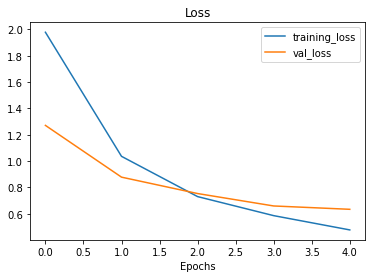

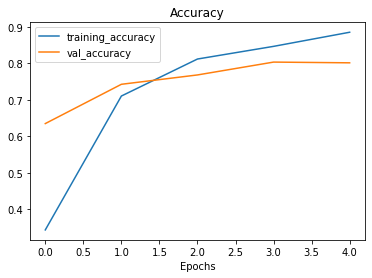

In [32]:
plot_loss_curves(mobilenet_history)

In [33]:
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              2257984   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [40]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/TensorFlow Developer Certificate"

/content/gdrive/MyDrive/Colab Notebooks/TensorFlow Developer Certificate


In [44]:
for dirpath, dirnames, filenames in os.walk("datasets/animals"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'datasets/animals'.
There are 10 directories and 0 images in 'datasets/animals/test'.
There are 0 directories and 20 images in 'datasets/animals/test/cavallo'.
There are 0 directories and 20 images in 'datasets/animals/test/gatto'.
There are 0 directories and 20 images in 'datasets/animals/test/ragno'.
There are 0 directories and 20 images in 'datasets/animals/test/cane'.
There are 0 directories and 20 images in 'datasets/animals/test/farfalla'.
There are 0 directories and 20 images in 'datasets/animals/test/scoiattolo'.
There are 0 directories and 20 images in 'datasets/animals/test/mucco'.
There are 0 directories and 20 images in 'datasets/animals/test/elefante'.
There are 0 directories and 20 images in 'datasets/animals/test/galinna'.
There are 0 directories and 20 images in 'datasets/animals/test/pacora'.
There are 10 directories and 0 images in 'datasets/animals/train'.
There are 0 directories and 20 images in 'datasets/animals/train/pacora'

In [73]:
classes = ["cane", "cavallo", "elefante", "farfalla", "galinna", "gatto", "mucco", "pacora", "ragno", "scoiattolo"]

In [45]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "datasets/animals/train"
test_dir = "datasets/animals/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_animals = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 200 images belonging to 10 classes.
Testing images:
Found 200 images belonging to 10 classes.


In [47]:
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data_10_animals.num_classes)

efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

efficientnet_history = efficientnet_model.fit(train_data_10_animals,
                                              epochs=5, 
                                              steps_per_epoch=len(train_data_10_animals),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                         experiment_name="efficientnetB0")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210620-083810
Epoch 1/5
7/7 [==============================] - 134s 21s/step - loss: 2.1658 - accuracy: 0.2900 - val_loss: 1.9013 - val_accuracy: 0.4800
Epoch 2/5
7/7 [==============================] - 2s 285ms/step - loss: 1.5555 - accuracy: 0.7100 - val_loss: 1.4649 - val_accuracy: 0.7400
Epoch 3/5
7/7 [==============================] - 2s 297ms/step - loss: 1.0335 - accuracy: 0.9150 - val_loss: 1.1540 - val_accuracy: 0.8050
Epoch 4/5
7/7 [==============================] - 2s 271ms/step - loss: 0.7349 - accuracy: 0.9550 - val_loss: 0.9314 - val_accuracy: 0.8400
Epoch 5/5
7/7 [==============================] - 2s 275ms/step - loss: 0.5013 - accuracy: 0.9700 - val_loss: 0.7783 - val_accuracy: 0.8700


In [91]:
# Create a function to import an image and resize it to be able to be used with our modle
def load_and_prep_image(filename, img_shape=224):
  test_images_dir = "datasets/animals/test_images/"
  img_url = test_images_dir + filename
  load_img = tf.io.read_file(img_url)
  decode_img = tf.image.decode_jpeg(load_img)
  resized_img = tf.image.resize(decode_img, [img_shape, img_shape])
  norm_img = resized_img/255.
  img = tf.expand_dims(norm_img, axis=0) # add an extra dimension at axis 0
  predict_index = np.argmax(efficientnet_model.predict(img))
  pred = classes[predict_index]
  plt.title(pred)
  plt.imshow(img[0])
  plt.show()

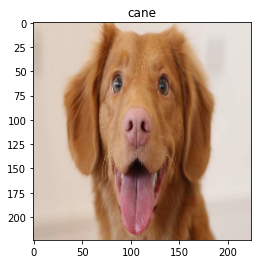

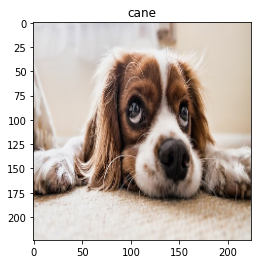

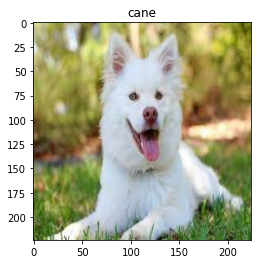

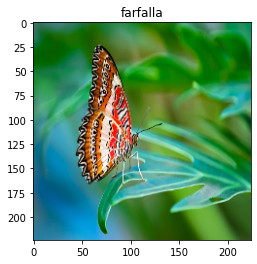

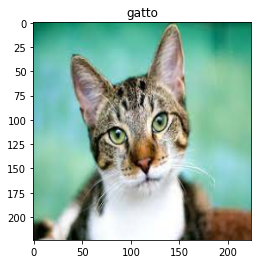

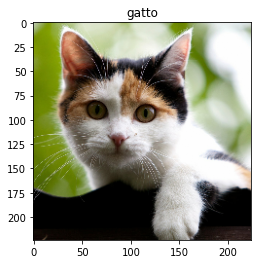

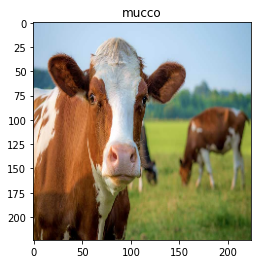

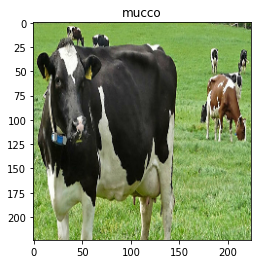

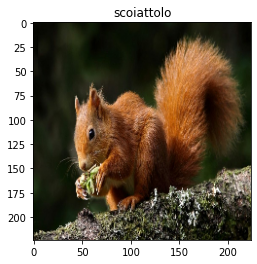

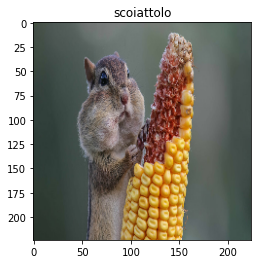

In [92]:
images_urls = ["dog1", "cane2", "cane3", "farfalla", "gatto1", "gatto2", "muco1", "muco2", "scoiattolo1", "scoiattolo2"]

for img_url in images_urls:
  load_and_prep_image(img_url + ".jpg")

In [94]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "efficientnet" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-06-20 09:18:27.931230: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/ix417QflRaua3vYbKRa2Kg/

[2021-06-20T09:18:29] Started scanning logdir.
[2021-06-20T09:18:30] Total uploaded: 30 scalars, 0 tensors, 1 binary objects (4.0 MB)
[2021-06-20T09:18:30] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/ix417QflRaua3vYbKRa2Kg/


In [95]:
!tensorboard dev delete --experiment_id ix417QflRaua3vYbKRa2Kg

2021-06-20 09:19:00.208382: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Deleted experiment ix417QflRaua3vYbKRa2Kg.
